# 🧑‍🎓 Students:

- Diyun LU
- Marwan MASHRA
- Yihan ZHONG

In [1]:
import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

# Deep Learning for NLP - lab exercise 1

In this first lab exercise we will implement a simple bag-of-word classifier, i.e. a classifier that ignores the sequential structure of the sentence, and a classifier based on a convolutional neural network (CNN). The goal is to predict if a sentence is a positive or negative review of a movie. We will use a dataset constructed from IMDB.

1. Load and clean the data
2. Preprocess the data for the NN
3. Module definition
4. Train the network!

We will implement this model with Pytorch, the most popular deep learning framework for Natural Language Processing. You can use the following links for help:
* turorials: http://pytorch.org/tutorials/
* documentation: http://pytorch.org/docs/master/ 

## Data

The data can be download here: http://caio-corro.fr/dl4nlp/imdb.zip

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.


The following functions can be used to load and clean the data.

In [2]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    dataset=[]
    with open(filename) as f:
        line = f.readline()
        cpt=1
        skip=0
        while line :
            cleanline = clean_str(f.readline()).split()
            if cleanline: 
                dataset.append(cleanline)
            else: 
                line = f.readline()
                skip+=1
                continue
            if limit > 0 and cpt >= limit: 
                break
            line = f.readline()
            cpt+=1        

        print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


The following cell load the first 5000 sentences in each review set.

In [3]:
LIM = 5000
txtfile = "data/imdb.pos"  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = "data/imdb.neg"  # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  data/imdb.pos  /  1  lines discarded
Load  5000  lines from  data/imdb.neg  /  1  lines discarded


Split the data between train / dev / test, for example by creating lists txt_train, label_train, txt_dev, ... You should take care to keep a 50/50 ratio between positive and negative instances in each set.

In [4]:
def shuffle_two_arrays(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return np.array(a,dtype=object)[p].tolist(), np.array(b,dtype=object)[p].tolist()

def split_data(start, end):
    txt, label = [], []
    txt.extend(postxt[start:end])
    label.extend(['pos']*(end-start))
    txt.extend(negtxt[start:end])
    label.extend(['neg']*(end-start))
    txt, label = shuffle_two_arrays(txt, label)
    return txt, label

assert len(postxt)==len(negtxt)
np.random.shuffle(postxt)
np.random.shuffle(negtxt)

dev_ratio, test_ratio = 0.2, 0.2
dev_size, test_size = int(dev_ratio*len(postxt)), int(test_ratio*len(postxt))
train_size = len(postxt) - dev_size - test_size

txt_train, label_train = split_data(0, train_size)
txt_dev, label_dev = split_data(train_size, train_size+dev_size)
txt_test, label_test = split_data(train_size+dev_size, train_size+dev_size+test_size)


# Converting data to Pytorch tensors

We will first convert data to Pytorch tensors so they can be used in a neural network.
To do that, you must first create a dictionnary that will map words to integers.
Add to the dictionnary only words that are in the training set (be sure to understand why we do that!).

Then, you can convert the data to tensors:
- use tensors of longs: both the sentence and the label will be represented as integers, not floats!
- these tensors do not require a gradient

A tensor representing a sentence is composed of the integer representation of each word, e.g. [10, 256, 3, 4].
Note that some words in the dev and test sets may not be in the dictionnary! (i.e. unknown words)
You can just skip them, even if this is a bad idea in general.

In [5]:
# get all unique words
WORDS = {}
for sentence in txt_train:
    for word in sentence:
        WORDS[word] = 0
for index, word in enumerate(WORDS):
    WORDS[word] = index+1

# max length
max_len = max(map(len,txt_train))

# create functions to map
def word_to_integer(word):
    return WORDS[word] if word in WORDS else 0

def sentence_to_integer(sentence):
    return list(map(word_to_integer, sentence))
def list_to_padded_tensor(list):
    pad = max_len-len(list)
    return F.pad(th.tensor(list, dtype=th.long, requires_grad=False), (0,pad))

def process_data(txt, label):
    label_int = list(map(lambda x: 1 if x=="pos" else 0, label))
    y = th.tensor(label_int, dtype=th.float32, requires_grad=False)

    data = list(map(sentence_to_integer, txt))
    data_tensor = list(map(list_to_padded_tensor, data))
    x = th.stack(data_tensor,dim=0)

    return  x, y

x_train, y_train = process_data(txt_train, label_train)
x_dev, y_dev = process_data(txt_dev, label_dev)
x_test, y_test = process_data(txt_test, label_test)   

x_train.shape, x_dev.shape, x_test.shape

(torch.Size([6000, 41]), torch.Size([2000, 41]), torch.Size([2000, 41]))

# Neural network definition

You need to implement two networks:

- a simple bag of word model (note: it may be better to take the mean of input embeddings that the sum)
- a simple CNN as described in the course

To simplify code, you can assume the input will always be a single sentence first, and then implement batched inputs. In the case of batched inputs, give to the forward function a (python) list of tensors.

The bag of word neural network should be defined as follows:
- take as input a tensor that is a sequence of integers indexing word embeddings
- retrieve the word embeddings from an embedding table
- construct the "input" of the MLP by summing (or computing the mean) over all embeddings (i.e. bag-of-word model)
- build a hidden represention using a MLP (1 layer? 2 layers? experiment! but maybe first try wihout any hidden layer...)
- project the hidden representation to the output space: it is a binary classification task, so the output space is a scalar where a negative (resp. positive) value means the review is negative (resp. positive).

The CNN is a little bit more tricky to implement. The goal is that you implement the one presented in the first lecture. Importantly, you should add "padding" tokens before and after the sentence so you can have a convolution even when there is a single word in the input.
For example, if you input sentence is ["word"], you want to instead consider the sentence ["\<BOS\>", "word", "\<EOS\>"] if your window is of size 2 or 3.
You can do this either directly when you load the data, or you can do that in the neural network module.

In [194]:
# BAG of word classifier
class CBOW_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_hidden=0, hidden_dim=10):
        super(CBOW_classifier, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.emb_table = th.nn.Embedding(self.vocab_size, self.embedding_dim)
        layers = []
        for i in range(num_hidden):
            if i==0: # first layer
                layers.append(nn.Linear(self.embedding_dim, hidden_dim))
            else:
                layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        self.layers = nn.ModuleList(layers)
        if num_hidden:
            self.proj = nn.Linear(hidden_dim, 1)
        else:
            self.proj = nn.Linear(self.embedding_dim, 1)

    def forward(self, inputs):
        # inputs[inputs>=self.vocab_size] = 0   # ignore new vocab 
        word_emb = self.emb_table(inputs)
        mask = (inputs!=0).to(th.int).unsqueeze(dim=2).expand(word_emb.size())
        word_emb *= mask
        
        sentence_emb = word_emb.mean(dim=1)
        x = sentence_emb
        for i in range(len(self.layers)):
            x = self.layers[i](x)

        logits = self.proj(x)
        return logits.squeeze()

    def predict(self, x):
        logits = self.forward(x)
        y_pred = (logits>=0).int()
        return y_pred
    
    def evaluate(self, x, y_gold):
        y_pred = self.predict(x)
        acc = ((y_pred == y_gold).int().sum()/x.size()[0]).item()
        return acc

## Loss function

Create a loss function builder.

- Pytorch loss functions are documented here: https://pytorch.org/docs/stable/nn.html#loss-functions
- In our case, we are interested in *BCELoss* and *BCEWithLogitsLoss*. Read their documentation and choose the one that fits with your network output

In [7]:
loss = nn.BCEWithLogitsLoss(reduction='none')
loss(c(x_train[:10]), y_train[:10])

torch.Size([10, 41, 128])
torch.Size([10, 128])


tensor([0.5854, 0.5839, 0.8153, 0.5848, 0.5858, 0.5856, 0.8122, 0.8181, 0.8172,
        0.8136], grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Training loop

Write your training loop!

- parameterizable number of epochs
- at each epoch, print the mean loss and the dev accuracy

In [67]:
def train(model, n_epoch=100, batch_size=256, lr=1e-3, early_stopping=True):
    early_stopping_limit = 3
    dev_loss_up = 0
    optimizer = th.optim.Adam(model.parameters(), lr=lr)
    loss_train = list()
    loss_dev = list()
    loss_function = nn.BCEWithLogitsLoss()
    for _ in range(n_epoch):
        losses_train = list()
        for i in range(0, x_train.shape[0], batch_size):
            optimizer.zero_grad()
            batch = x_train[i:i+batch_size]
            gold = y_train[i:i+batch_size]
            logits = model(batch)
            loss = loss_function(logits, gold)
            losses_train.append(loss.item())
            loss.backward()
            th.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
        mean_train_loss = sum(losses_train)/len(losses_train)
        print(f"loss {mean_train_loss:.3f}", end='\r', flush=True)
        loss_train.append(mean_train_loss)
        loss_dev.append(loss_function(model(x_dev), y_dev).item())

        if early_stopping: 
            if len(loss_dev)>5 and loss_dev[-1]>=loss_dev[-2]:
                dev_loss_up += 1
            else:
                dev_loss_up = 0
            if dev_loss_up==early_stopping_limit:
                break
    return loss_train, loss_dev

In [145]:
models = {}

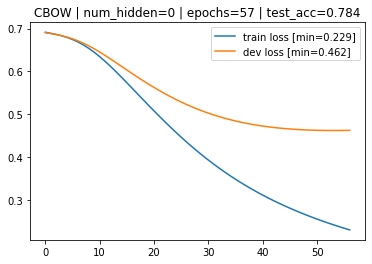

In [156]:
embedding_dim = 64
model_name = 'cbow_hidden(0)'

models[model_name] = {}
models[model_name]['model'] = CBOW_classifier(len(WORDS)+1, embedding_dim, num_hidden=0)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CBOW | num_hidden=0 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

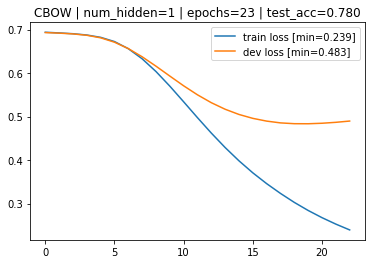

In [157]:
model_name = 'cbow_hidden(1)'

models[model_name] = {}
models[model_name]['model'] = CBOW_classifier(len(WORDS)+1, embedding_dim, num_hidden=1)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CBOW | num_hidden=1 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

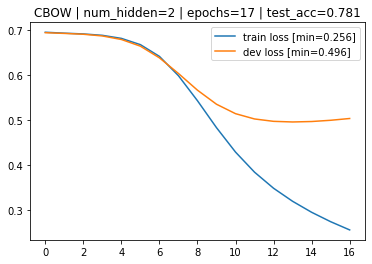

In [158]:
model_name = 'cbow_hidden(2)'

models[model_name] = {}
models[model_name]['model'] = CBOW_classifier(len(WORDS)+1, embedding_dim, num_hidden=2)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CBOW | num_hidden=2 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

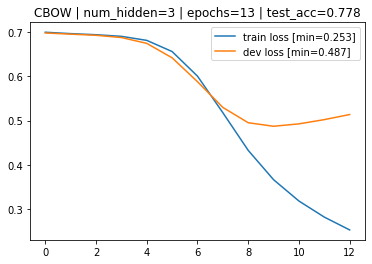

In [193]:
model_name = 'cbow_hidden(3)'

models[model_name] = {}
models[model_name]['model'] = CBOW_classifier(len(WORDS)+1, embedding_dim, num_hidden=3)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CBOW | num_hidden=3 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

In [159]:
# BAG of word classifier
class CNN_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim,hidden=False,hidden_dim=10,window_size=2, dropout=0.0):
        super(CNN_classifier, self).__init__()
        self.emb_table = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim
        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(self.window_size*self.embedding_dim,hidden_dim) #input size and output size

        if not hidden:
            self.classifier = nn.Linear(hidden_dim,1)
        else:
            self.classifier = nn.Sequential(
                nn.Linear(hidden_dim,hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim,1)
            )
    
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        
    def forward(self, inputs):
        word_emb = self.emb_table(inputs)
        mask = (inputs!=0).to(th.int).unsqueeze(dim=2).expand(word_emb.size())
        word_emb *= mask
        batch_size,words,embedding_size = word_emb.size()
        z = th.zeros((batch_size,words-self.window_size+1,self.window_size*self.embedding_dim))
        for step in range(words-self.window_size+1):
            z[:,step,:] = word_emb[:,step:self.window_size+step,:].reshape(z[:,step,:].size())
        z = self.proj(z)
        z, _ = th.max(z, dim=1)
        z = nn.ReLU()(z) #hidden representation of a sentence
        z = self.dropout(z)
        output=self.classifier(z)
        return output.squeeze() # remove unnecessary dimension

    def predict(self, x):
        logits = self.forward(x)
        y_pred = (logits>=0).int()
        return y_pred
    
    def evaluate(self, x, y_gold):
        y_pred = self.predict(x)
        acc = ((y_pred == y_gold).int().sum()/x.size()[0]).item()
        return acc

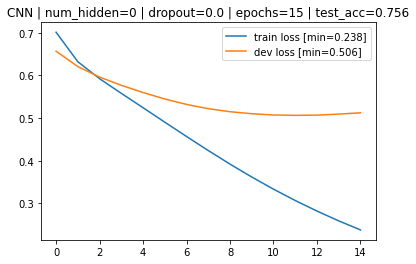

In [160]:
embedding_dim = 128
model_name = 'cnn_hidden(0)_dropout(0)'

models[model_name] = {}
models[model_name]['model'] = CNN_classifier(len(WORDS)+1, embedding_dim)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CNN | num_hidden=0 | dropout=0.0 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

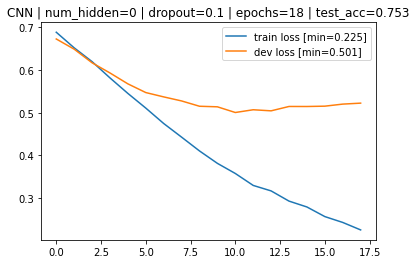

In [161]:
model_name = 'cnn_hidden(0)_dropout(0.1)'

models[model_name] = {}
models[model_name]['model'] = CNN_classifier(len(WORDS)+1, embedding_dim, dropout=0.1)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CNN | num_hidden=0 | dropout=0.1 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

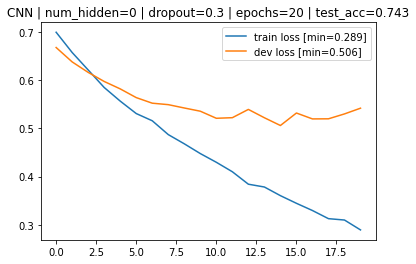

In [163]:
model_name = 'cnn_hidden(0)_dropout(0.3)'

models[model_name] = {}
models[model_name]['model'] = CNN_classifier(len(WORDS)+1, embedding_dim, dropout=0.3)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CNN | num_hidden=0 | dropout=0.3 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

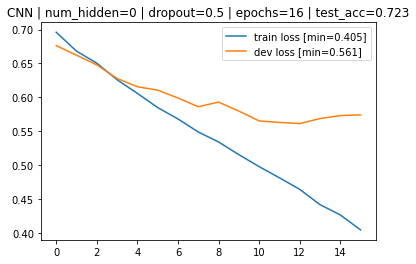

In [162]:
model_name = 'cnn_hidden(0)_dropout(0.5)'

models[model_name] = {}
models[model_name]['model'] = CNN_classifier(len(WORDS)+1, embedding_dim, dropout=0.5)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CNN | num_hidden=0 | dropout=0.5 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

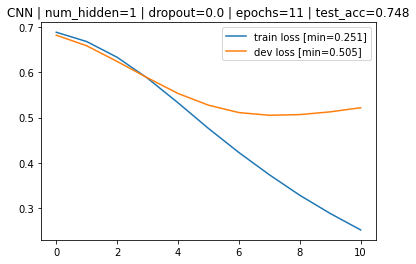

In [164]:
model_name = 'cnn_hidden(1)_dropout(0.0)'

models[model_name] = {}
models[model_name]['model'] = CNN_classifier(len(WORDS)+1, embedding_dim, hidden=True)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CNN | num_hidden=1 | dropout=0.0 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

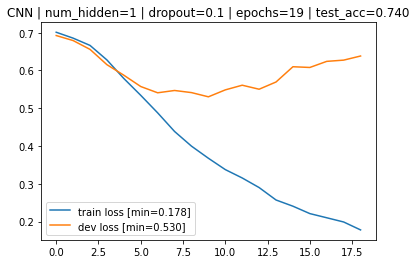

In [165]:
model_name = 'cnn_hidden(1)_dropout(0.1)'

models[model_name] = {}
models[model_name]['model'] = CNN_classifier(len(WORDS)+1, embedding_dim, hidden=True, dropout=0.1)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CNN | num_hidden=1 | dropout=0.1 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

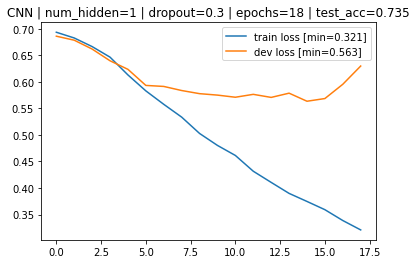

In [166]:
model_name = 'cnn_hidden(1)_dropout(0.3)'

models[model_name] = {}
models[model_name]['model'] = CNN_classifier(len(WORDS)+1, embedding_dim, hidden=True, dropout=0.3)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CNN | num_hidden=1 | dropout=0.3 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

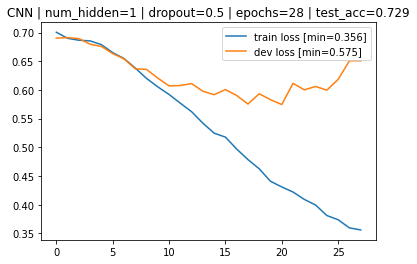

In [167]:
model_name = 'cnn_hidden(1)_dropout(0.5)'

models[model_name] = {}
models[model_name]['model'] = CNN_classifier(len(WORDS)+1, embedding_dim, hidden=True, dropout=0.5)
model = models[model_name]['model']

loss_train, loss_dev = train(model)
models[model_name]['loss_train'], models[model_name]['loss_dev'] = loss_train, loss_dev

plt.plot(np.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
plt.plot(np.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
plt.legend()
plt.title(f"CNN | num_hidden=1 | dropout=0.5 | epochs={len(loss_dev)} | test_acc={model.evaluate(x_test, y_test):.3f}")
plt.show()

# Data Analysis

In [186]:
shared_mistakes = th.ones_like(y_test)
for model_name, model in models.items():
    y_pred = model['model'].predict(x_test)
    mistakes = (y_pred != y_test).int()
    shared_mistakes *= mistakes

mistakes_indices = shared_mistakes.bool().nonzero().squeeze()
list_mistakes = np.array(txt_train, dtype=np.object_)[mistakes_indices].tolist()
list_answers = y_test[mistakes_indices]
print(f"There is {len(list_mistakes)} shared mistake")

There is 50 shared mistake


In [192]:
for i in range(len(list_mistakes)):
    answer = "positive" if list_answers[i] else "negative"
    print(f"{i}) {answer} => {' '.join(list_mistakes[i])}")

0) negative => an abomination
1) negative => what in the world were they thinking
2) positive => a movie for the common folk with brains !
3) positive => poor movie just to make some funds on something weird
4) positive => wonderful fun !
5) positive => one horse race to nowhere
6) negative => sparkling , ground breaking ourdoor musical 3 guys , 3 gals and 3 x the fun
7) positive => simply astonishing !
8) negative => horrid writing , deplorable casting and acting that would make b movie actors look away in shame
9) positive => mediocre and generic rubbish
10) positive => absolutely beautiful !
11) positive => a very good little thriller
12) positive => a different tale , sends a strong message
13) positive => one of my all time favorites
14) positive => it 's time for the organ transplant you 're the donor and i'm the recipient
15) positive => believe me , you can avoid this one
16) negative => ehhhhh , no
17) positive => just as bad as amores perros
18) negative => it would be no sur

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=510eed3f-cfe8-4b8a-9785-d4723865ac9d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>